### Cella usa e getta (ogni volta che re-inizializzi il kernel)

In [3]:
# libraries
import os
import sys
import platform
print(sys.version)

strong_pc = platform.system() == 'Linux'
in_colab = 'google.colab' in sys.modules
if in_colab:
    if not os.getcwd().split('/')[-1].split('_')[-1]=='2023':
        from google.colab import drive
        drive.mount('/content/drive')
        os.chdir(r'/content/drive/MyDrive/Human_Data_Analytics_Project_2023')

    if not 'tensorflow_io' in sys.modules:
        print('Installing tensorflow-IO')
        !pip install tensorflow-io
    if not 'keras' in sys.modules:
        print('Installing keras')
        !pip install keras==2.10.0
    if not 'scikeras' in sys.modules:
        print('Installing scikeras')
        !pip install scikeras[tensorflow]
    if not 'keras-tuner' in sys.modules:
        print('installing keras tuner')
        !pip install keras-tuner
        !pip install numba==0.57.0


if 'DEEPNOTE_ENV' in os.environ:
    os.chdir('/..')
    os.chdir('datasets')
    os.chdir('googledrivedeepnoteintegration')
    os.chdir('Human_Data_Analytics_Project_2023')
    if not 'librosa' in sys.modules:
        print('Installing Librosa')
        !pip install librosa
    if not 'scikeras' in sys.modules:
        print('Installing scikeras')
        !pip install scikeras[tensorflow]
    if not 'keras-tuner' in sys.modules:
        print('installing keras tuner')
        !pip install keras-tuner
        !pip install numba==0.57.0

main_dir = os.getcwd()
if main_dir not in sys.path:
    print('Adding the folder for the modules')
    sys.path.append(main_dir)

#BASE LIBRARIES
import numpy as np
import pandas as pd
import h5py
import shutil
import time
import random
import subprocess
import itertools
import warnings
import pickle
import json

#PLOT LIBRARIES
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
sb.set(style="white", palette="muted")
import IPython.display as ipd
#import plotly.express as px

#AUDIO LIBRARIES
import librosa
from scipy.io import wavfile
from scipy import signal
from scipy.fft import fft,ifft,fftfreq, fftshift
from scipy.signal import stft,spectrogram,periodogram
#from pydub import AudioSegment

#MACHINE LEARNING LIBRARIES
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, LeaveOneOut, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.utils import check_random_state
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from tensorflow.keras.models import load_model

# GPU SETTINGS FOR LINUX and repressing warnings for windows. References for gpu: https://www.tensorflow.org/guide/gpu 
show_gpu_activity = False 
if sys.platform == 'linux':
    if show_gpu_activity:
        tf.debugging.set_log_device_placement(True)

    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
    # Restrict TensorFlow to only allocate a part of memory on the first GPU
        try:
            tf.config.set_logical_device_configuration(
                gpus[0],
                [tf.config.LogicalDeviceConfiguration(memory_limit=6800)])
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Virtual devices must be set before GPUs have been initialized
            print(e)
else:
    warnings.filterwarnings("ignore", category=UserWarning)

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import plot_model as tf_plot
if in_colab:
    import tensorflow_io as tfio
print("TensorFlow version:", tf.__version__)
# show keras version
import keras
print(f'keras version = {keras.__version__}')
#import keras_tune as kt
from keras import layers
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.regularizers import L1L2
# kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4) # we may use this in some layers...

#RANDOM SETTINGS
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
check_random_state(seed)

#EVALUATION LIBRAIRES
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve
from sklearn.metrics import make_scorer
from sklearn.metrics import RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import precision_recall_fscore_support, auc

#OUR PERSONAL FUNCTIONS
import importlib
from Preprocessing.data_loader import download_dataset,load_metadata
from Preprocessing.exploration_plots import one_random_audio, plot_clip_overview, Spectral_Analysis
from Models.basic_ml import basic_ML_experiments, basic_ML_experiments_gridsearch, build_dataset, extract_flatten_MFCC
from Visualization.model_plot import confusion_matrix,listen_to_wrong_audio

importlib.reload(importlib.import_module('Preprocessing.data_loader'))
importlib.reload(importlib.import_module('Models.basic_ml'))
importlib.reload(importlib.import_module('Visualization.model_plot'))

from Preprocessing.data_loader import load_metadata
df_ESC10, df_ESC50 = load_metadata(main_dir,heads = False, ESC_US = False, statistics=False)

from Preprocessing.data_loader import load_metadata
from Models.basic_ml import basic_ML_experiments, basic_ML_experiments_gridsearch, build_dataset, extract_flatten_MFCC

importlib.reload(importlib.import_module('Models.ann_utils'))
importlib.reload(importlib.import_module('Visualization.model_plot'))

from Models.ann_utils import *
from Models.ann_utils import MFCCWithDeltaLayer,OutputCutterLayer
from Visualization.model_plot import plot_history, confusion_matrix, listen_to_wrong_audio, visualize_the_weights

ESC10_path = os.path.join(main_dir,'data', 'ESC-10-depth')
samplerate = 44100

3.10.9 | packaged by Anaconda, Inc. | (main, Mar  8 2023, 10:42:25) [MSC v.1916 64 bit (AMD64)]
TensorFlow version: 2.12.0
keras version = 2.10.0


# 4 ENCODER FOR HIGH-LEVEL FEATURE EXTRACTION

In [20]:
import importlib
importlib.reload(importlib.import_module('Models.ann_utils'))
importlib.reload(importlib.import_module('Visualization.model_plot'))
importlib.reload(importlib.import_module('Preprocessing.data_loader'))
from Models.ann_utils import *
from Preprocessing.data_loader import reshape_US
from Visualization.model_plot import *

## 4.1 Classification on encoded raw audio

Since neither the basic machine learning appraches nor the dense feed forward NNs were able to achieve a good accuracy, we decided to use only the RNN approach, which at least achived alone 28% of accurcy on the 10 class classification problem from raw audio. 

### Create the dataset

Audio shape: (30, 220500, 1)
Label shape: (30, 10)
Label: dog


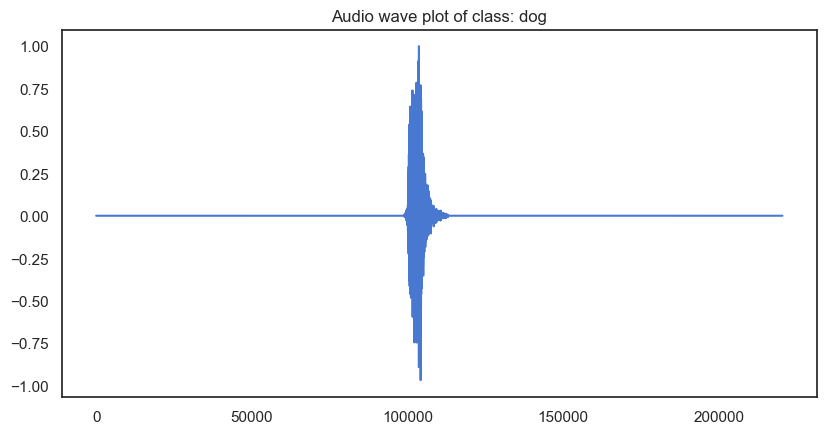

In [4]:
batch_size = 30 if not strong_pc else 128

dataset, label = create_dataset_lite(df_ESC10,
                                     batch_size = batch_size,
                                     ndim = 2)
INPUT_DIM, n_labels = example_batch(dataset, label_names = list(label.columns), verbose = 1)

### Load the encoder and build the model

In [23]:
AE_name = 'Dense_AE_ffnn_fake'
path_to_AE = os.path.join(main_dir, 'Saved_Models', AE_name)

#import the autencoder
autoencoder = load_model(path_to_AE)
encoder = autoencoder.layers[1]

# freeze the encoder
encoder.trainable = False
encoder.summary()

Classifier_name = 'encoder_classifier_raw'


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 220500)            0         
                                                                 
 dense_34 (Dense)            (None, 64)                14112064  
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                                                                 
 dense_35 (Dense)            (None, 32)                2080      
                                                                 
 dropout_19 (Dropout)        (None, 32)                0         
                                                                 
 dense_36 (Dense)            (None, 16)                528       
                                                                 
 dropout_20 (Dropout)        (None, 16)              

In [31]:
def build_model(
    encoder = encoder,
    n_labels = n_labels,
    INPUT_DIM = INPUT_DIM,
    n_units = 8,
    activation = 'tanh',
    #arguments to compile the model
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    learning_rate = 1e-3,
    metrics = ['accuracy'],
    verbose = 0,
    compile = True,
    name = Classifier_name
):

    classifier = tf.keras.Sequential([
        tf.keras.layers.GRU(units=n_units, activation=activation),
        tf.keras.layers.Dense(n_labels, activation='softmax')
    ], name = 'Classifier')

    # build the autoencoder with keras.Model
    inp = tf.keras.Input(shape = INPUT_DIM)
    code = encoder(inp)
    # add 1 dimension to the code
    code = tf.expand_dims(code, axis = 2)
    output = classifier(code)
    model = tf.keras.Model(inputs=inp, outputs=output, name = Classifier_name)

    # compile the autoencoder
    lr = learning_rate
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr) if sys.platform == 'darwin' or in_colab else tf.keras.optimizers.Adam(learning_rate = lr)
    loss = loss
    metrics = metrics

    if compile:
        # compile the model
        model.compile(loss = loss,
                    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate) if sys.platform == 'darwin' or in_colab else tf.keras.optimizers.Adam(learning_rate=learning_rate),
                    metrics = metrics)
        if verbose > 0:
            model.summary()
    
    return model

In [32]:
model = build_model()
model.summary()

Model: "encoder_classifier_raw"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 220500, 1)]       0         
                                                                 
 sequential_10 (Sequential)  (None, 16)                14114944  
                                                                 
 tf.expand_dims_2 (TFOpLambd  (None, 16, 1)            0         
 a)                                                              
                                                                 
 Classifier (Sequential)     (None, 10)                354       
                                                                 
Total params: 14,115,298
Trainable params: 354
Non-trainable params: 14,114,944
_________________________________________________________________


### Run a Grid Search to find the best hyperparameters

In [34]:
params = {'learning_rate':[1e-3, 1e-4]}
#params = {'learning_rate':[1e-2, 1e-3, 1e-4],'n_units':[8,32,128],'activation':['relu','elu','tanh']}
epochs = 1 if not strong_pc else 100
patience = 10
verbose = 3
K_fold = 5
model_cv, result, best_params = K_fold_training(dataset, 
                                                build_model, 
                                                params = params, 
                                                epochs = epochs,
                                                patience = patience, 
                                                verbose = verbose, 
                                                K=K_fold)


(400, 220500, 1)
(400, 10)
Fitting 5 folds for each of 2 candidates, totalling 10 fits
3/3 [==============================] - 1s 24ms/step
accuracy on test for this fold is 0.0875
3/3 [==============================] - 1s 22ms/step
accuracy on test for this fold is 0.1
3/3 [==============================] - 1s 19ms/step
accuracy on test for this fold is 0.1
3/3 [==============================] - 1s 24ms/step
accuracy on test for this fold is 0.175
3/3 [==============================] - 1s 22ms/step
accuracy on test for this fold is 0.1
3/3 [==============================] - 1s 29ms/step
accuracy on test for this fold is 0.125
3/3 [==============================] - 1s 22ms/step
accuracy on test for this fold is 0.0625
3/3 [==============================] - 1s 31ms/step
accuracy on test for this fold is 0.1
3/3 [==============================] - 1s 23ms/step
accuracy on test for this fold is 0.1
3/3 [==============================] - 1s 23ms/step
accuracy on test for this fold is 0.05
Th

,mean_accuracy
{'learning_rate': 0.001},0.1125
{'learning_rate': 0.0001},0.0875


### Train the model

Found 400 files belonging to 10 classes.
Using 300 files for training.
Using 100 files for validation.
Model: "encoder_classifier_raw"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 220500, 1)]       0         
                                                                 
 sequential_10 (Sequential)  (None, 16)                14114944  
                                                                 
 tf.expand_dims_14 (TFOpLamb  (None, 16, 1)            0         
 da)                                                             
                                                                 
 Classifier (Sequential)     (None, 10)                354       
                                                                 
Total params: 14,115,298
Trainable params: 354
Non-trainable params: 14,114,944
___________________________________________________________

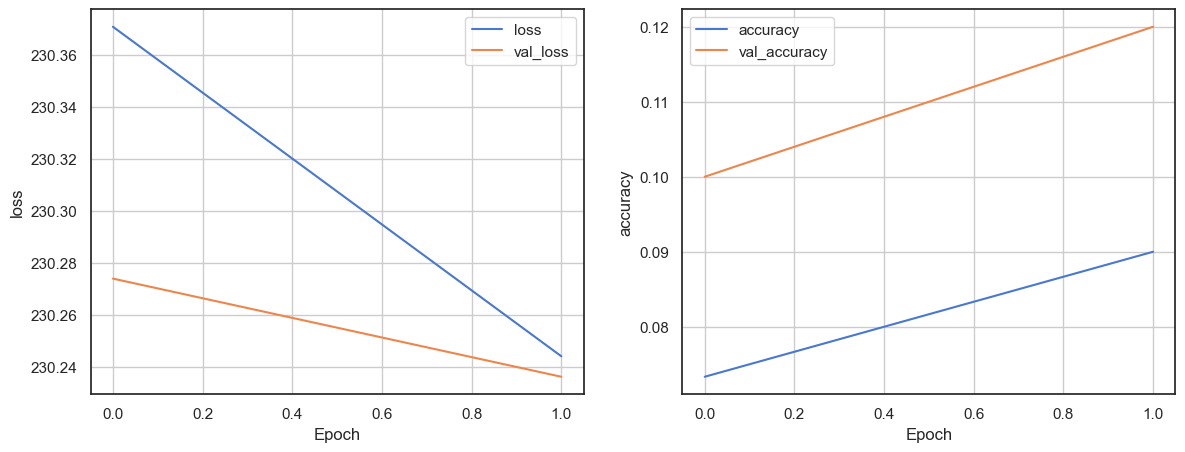

2/2 [==============================] - 2s 568ms/step - loss: 2.3060 - accuracy: 0.0200


{'loss': 2.306018352508545, 'accuracy': 0.019999999552965164}

2/2 [==============================] - 1s 19ms/step


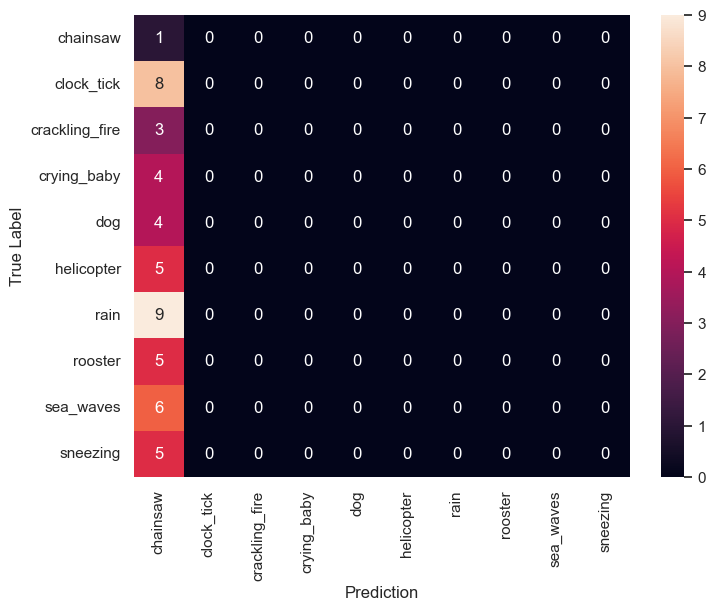

The most misclassified class is chainsaw
Audio category: chainsaw


The are more audio predicted as chainsaw then actually is:
Audio category misclassified as chainsaw: rain


In [37]:
seed = 42
tf.random.set_seed(seed)

path_to_ESC10 = os.path.join(main_dir,'data', 'ESC-10-depth')

#create the dataset
batch_size = 30
preprocessing = None
train, val, test, label_names, INPUT_DIM, n_labels = create_dataset(path_to_ESC10,
                                                                      batch_size = batch_size,  # batch size
                                                                      preprocessing = preprocessing,
                                                                      verbose = 0,
                                                                      show_example_batch = True,
                                                                      ndim = 2,
                                                                      )

#build the model with the best parameters                                                         
model = build_model(n_labels = n_labels, compile = False, **best_params)
learning_rate = best_params['learning_rate']
epochs =  2 if not strong_pc else 100
patience = 10
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate) if sys.platform == 'darwin' or in_colab else tf.keras.optimizers.Adam(learning_rate=learning_rate)
model, history, confusion_mtx, evaluation = compile_fit_evaluate(df_ESC10, model, train, val,test,label_names,
                                     epochs = epochs,
                                     patience = patience,
                                     loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                                     optimizer = optimizer,
                                     metrics = ['accuracy'],
                                     verbose = 1,
                                     show_history = True,
                                     show_test_evaluation = True,
                                     show_confusion_matrix = True,
                                     listen_to_wrong = True)

## 4.2 Classification on encoded spectrograms - RNN

### Create the dataset

Preprocessing: MFCC
Resizing with shape: 64x128
The max value is 367.3448181152344
Audio shape: (30, 64, 128, 1)
Label shape: (30, 50)
Label: dog


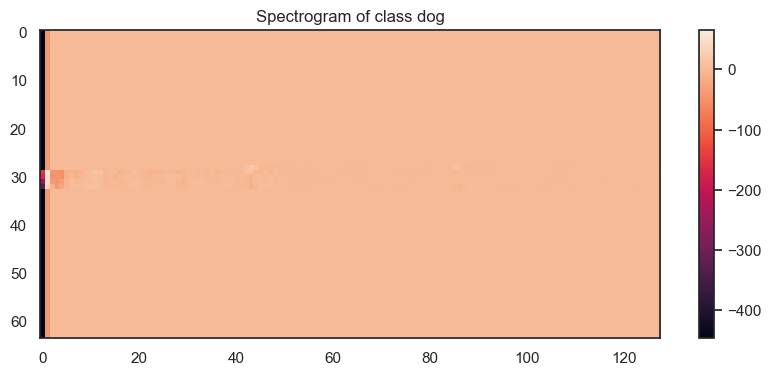

In [22]:
batch_size = 30 if not strong_pc else 128
preprocessing = 'STFT'
n_dim = 3

dataset_STFT, label_STFT = create_dataset_lite(df_ESC50,
                                         batch_size = batch_size,
                                         preprocessing = preprocessing,
                                         ndim = n_dim,
                                         resize = True)

INPUT_DIM, n_labels = example_batch(dataset_STFT, label_names = list(label_STFT.columns),verbose=2, show_figure = True)

### Load the encoders and build the model

We trained 2 AEs to produce a vectorial code. On these code we are going to train a RNN classifier.

In [6]:
AE_STFT = 'AE_Conv_prep_flatten_STFT'
AE_MFCC = 'AE_Conv_prep_flatten_MFCC'
encoder_list = []
for AE_name in [AE_STFT,AE_MFCC]:
    path_to_AE = os.path.join(main_dir, 'Saved_Models',AE_name)

    #import the autencoder
    autoencoder = load_model(path_to_AE)
    encoder = autoencoder.layers[1]

    # freeze the encoder
    encoder.trainable = False
    encoder.summary()

    encoder_list.append(encoder)

Classifier_name = 'encoder_classifier_raw'

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 21, 42, 16)        160       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 14, 16)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1568)              0         
                                                                 
 dense_2 (Dense)             (None, 32)                50208     
                                                                 
Total params: 50,368
Trainable params: 0
Non-trainable params: 50,368
_________________________________________________________________
Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Sh

In [ ]:
def build_model(
        INPUT_DIM = INPUT_DIM,
        n_labels = n_labels,
        
)

Performing the k fold search

In [ ]:
epochs = 100
patience = 10
params = {'n_units':[64, 128], 'activation':['relu','tanh'], 'learning_rate':[1e-2,1e-3, 1e-4]}
K_fold = 5

model_cv, result, best_params = K_fold_training(encoded_dataset, build_model, params = params, epochs =  epochs, patience = patience, verbose = 0, K=K_fold)

### GRU From 2.4.1 

In [ ]:
batch_size = 20

dataset, label = create_dataset_lite(df_ESC50,
                                     batch_size = batch_size,
                                     preprocessing = None,
                                     ndim = 2)
INPUT_DIM, n_labels = example_batch(dataset, label_names = list(label.columns), verbose = 0)

In [ ]:
encoded_dataset, ENCODED_INPUT_DIM = encode_dataset(dataset, encoder)

#transform ENCODED_INPUT_DIM from (code_size,) to TensorShape([code_size, 1])
ENCODED_INPUT_DIM = tf.TensorShape([ENCODED_INPUT_DIM[0], 1])

In [ ]:
#%%capture captured_output
# https://pypi.org/project/silence-tensorflow/       altra speranza per mutare il log di tensorflow


def build_model( n_labels = n_labels,   # arguments to build the model
                 INPUT_DIM = ENCODED_INPUT_DIM,
                 n_filters = 1,
                 n_units = 8,
                 kernel_size = 18,
                 activation = 'tanh',
                 #arguments to compile the model
                 loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 learning_rate = 1e-3,
                 metrics = ['accuracy'],
                 verbose = 0):
    strides = int(kernel_size/2)
    model = tf.keras.Sequential([
        #reduce the dimensionality of the input with a 1DConvolution
        tf.keras.layers.Conv1D(filters=n_filters, kernel_size = kernel_size, strides=strides, activation=activation, input_shape=ENCODED_INPUT_DIM),
        #with more than 1 filters I'll have prpoblems with the channel dimension not accepted by Recurrent layers
        #apply a SimpleRNN layer
        tf.keras.layers.GRU(units=n_units, activation=activation),
        tf.keras.layers.Dense(n_labels, activation='softmax')
    ])

    # compile the model
    model.compile(loss = loss,
                  optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate) if sys.platform == 'darwin' or in_colab else tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics = metrics)
    if verbose > 0:
        model.summary()

    print(f'filters {n_filters}, kernel size {kernel_size}, units of GRU {n_units}, lr {learning_rate}, activation {activation}, strides {strides}')
    print(f' Trainable parameters: {model.count_params()}')
    return model

epochs = 100
patience = 10

params = {'n_filters':[1],'kernel_size':[4,8,16], 'learning_rate':[1e-3, 1e-4], 'n_units':[4,8,16],'activation':['tanh']}
K_fold = 5
model_cv, result, best_params = K_fold_training(encoded_dataset, build_model, params = params, epochs = epochs, patience = patience, verbose = 0, K=K_fold)


#save captured_output.stdout to a file

#with open("log_gru_encoded.txt", "w") as file:
    #file.write(captured_output.stdout)

## Tensorial (Change name) latent space

In [ ]:
from tensorflow.keras.models import load_model

#import the encoder in subfolder "Leo" named working_encoder.h5
encoder = load_model('Leo/working_encoder_tensor.h5')

In [ ]:
#autoencoder.summary()

In [ ]:
#Try the encoder on a random generated sample

a = encoder(np.random.uniform(1, -1, size=(1, 64, 128, 1)))
a.shape

### From basic machine learning

dovrei riscrivere le funzioni di basic machine learning in modo che ci sia la possibilità di scegliere se usare MFCC, MEL, STFT nel caso del capitolo 2. Inoltre serve anche che si possa fare basic ml anche su flatten code (simile al raw audio) o su un tensore (simile a qualcosa di preprocessed come MFCC, ...) 

### From CNN 2.3.1

In [ ]:
importlib.reload(importlib.import_module('Models.ann_utils'))
from Models.ann_utils import create_dataset, compile_fit_evaluate, K_fold_training, create_dataset_lite

In [ ]:
batch_size = 25

dataset, label = create_dataset_lite(df_ESC50,
                                     batch_size = batch_size,
                                     preprocessing = 'STFT',
                                     ndim = 3)
INPUT_DIM, n_labels = example_batch(dataset, label_names = list(label.columns))

In [ ]:
def resize_images(image, new_height = 64, new_width = 128):
    # INPUT: the audio preprocessed by STFT, MEL or MFCC
    # OUTPUT: the audio reshaped as a tensor (needed for the convolutional layers)
    image = tf.image.resize(image, [new_height, new_width])
    return image

dataset = dataset.map(lambda audio, label: (tf.py_function(func=resize_images, inp=[audio], Tout=tf.float32), label),
                            num_parallel_calls=tf.data.AUTOTUNE,
                            deterministic=False)

In [ ]:
def find_max_lazy(dataset, verbose = 1):
    max = 0
    lazy_number = 4
    for elem, label in dataset.take(lazy_number):
        new = tf.reduce_max(tf.abs(elem)) 
        if new > max:
            max = new
    if verbose > 0:
        print(f'The max value is {max}')
    return max.numpy(), elem.numpy()

max, _ = find_max_lazy(dataset, verbose = 1)

dataset = dataset.map(lambda audio, label: (audio/max, label), num_parallel_calls=tf.data.AUTOTUNE, deterministic = False)

In [ ]:
def encode_dataset(dataset, encoder, dataset_type = 'tf'):  
    # dataset = dataset to encode which can be a tf.data.Dataset or a numpy array
    # in the case of a tf dataset the dataset contains both examples and labels; in the case of a numpy array the dataset contains only examples
    # type = 'tf' or 'np' if you want to encode the dataset in tensorflow or numpy
    # encoder = encoder to use to encode the dataset 
    # ENCODED_INPUT_DIM = dimension of the encoded dataset
    # note: we still have to test the funciton on a image dataset

    if dataset_type == 'tf':
        dataset = dataset.map(lambda x, lab: (encoder(x), lab))
        for example, _ in dataset.take(1):
            ENCODED_INPUT_DIM = example.shape

    if dataset_type == 'np':
        dataset = encoder(dataset).numpy()
        ENCODED_INPUT_DIM = (dataset.shape[1],)
    return dataset, ENCODED_INPUT_DIM

In [ ]:
dataset, ENCODED_INPUT_DIM = encode_dataset(dataset, encoder, dataset_type = 'tf')
print(ENCODED_INPUT_DIM)

In [ ]:
n_labels

In [ ]:
for i,j in dataset.take(1):
    print(i.shape)

In [ ]:
ENCODED_INPUT_DIM

In [ ]:
n_units = 4
kernel_size = (2,2,2)
activation = 'relu'
INPUT_DIM = ENCODED_INPUT_DIM + (1,)
l = tf.keras.layers.Conv3D(n_units, kernel_size, strides = 2 ,activation=activation, input_shape=INPUT_DIM, padding="same")

In [ ]:
INPUT_DIM

In [ ]:
print(ENCODED_INPUT_DIM)
# add a dimension to ENCODED_INPUT_DIM
ENCODED_INPUT_DIM_2 = ENCODED_INPUT_DIM + (1,)
print(ENCODED_INPUT_DIM_2)

r = np.random.uniform(-1,1,ENCODED_INPUT_DIM_2)
print(r.shape)
l(r)

In [ ]:
def build_model( n_labels = n_labels,   # arguments to build the model
                 INPUT_DIM = ENCODED_INPUT_DIM,
                 n_units = 8,
                 kernel_size = (3,3,3),
                 activation = 'relu',
                 #arguments to compile the model
                 loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 learning_rate = 1e-3,
                 metrics = ['accuracy'],
                 verbose = 0):

    model = tf.keras.models.Sequential([

        tf.keras.layers.InputLayer(input_shape=INPUT_DIM),

        # Convolutional layer 1
        tf.keras.layers.Conv3D(n_units, kernel_size, strides = 2 ,activation=activation, padding="same"),
        tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2), padding = 'same'),

        # Convolutional layer 2
        tf.keras.layers.Conv3D(2*n_units, (3, 3, 3), strides = 2 ,  activation=activation, padding="same"),
        tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2), padding = 'same'),

        # Flatten the output of the previous layer
        tf.keras.layers.Flatten(),

        # Dense layer for classification
        tf.keras.layers.Dense(n_labels, activation='softmax')  # Assuming 10 classes for classification
    ], name = 'CNN')

    model.summary()

    model.compile(loss = loss,
                  optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate) if sys.platform == 'darwin' or in_colab else tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics = metrics)
    if verbose > 0 :
        model.summary()

    print(f'n_units {n_units}, activation {activation}, learning_rate {learning_rate}, kernel size {kernel_size}')

    return model

epochs = 5
patience = 20
params = {'n_units':[4], 'activation':['relu','tanh'], 'learning_rate':[1e-3, 1e-4], 'kernel_size':[(3,3,3), (2,2,2)]}
K_fold = 5

model_cv, result, best_params = K_fold_training(dataset, build_model, params = params, epochs =  epochs, patience = patience, verbose = 1, K=K_fold)


In [ ]:
#refit only the best model
#best_params = {'activation': 'relu', 'kernel_size': (7, 7), 'learning_rate': 0.001, 'n_units': 64}	# best parameters from the grid search
seed = 42
tf.random.set_seed(seed)
ESC10_path = os.path.join(main_dir,'data', 'ESC-10-depth')
batch_size = 30
preprocessing = 'STFT'

train, val, test, label_names, INPUT_DIM, n_labels = create_dataset( ESC10_path,
                                                verbose = 1,
                                                batch_size = batch_size,
                                                validation_split = 0.25, # this is the splitting of train vs validation + test
                                                normalize = True, # normalization preprocessing (default is true)
                                                preprocessing = preprocessing,   # "STFT", "MEL", "MFCC" or None
                                                show_example_batch = True,
                                                ndim=3)


In [ ]:
#build the model
unit = best_params['n_units']
activation_fc = best_params['activation']
model = tf.keras.models.Sequential([
    # Convolutional layer 1
    tf.keras.layers.Conv2D(unit, best_params['kernel_size'], strides = 2 ,activation=activation_fc, input_shape=INPUT_DIM, padding="same"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Convolutional layer 2
    tf.keras.layers.Conv2D(2*unit, (3, 3), strides = 2 ,  activation=activation_fc, padding="same"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Convolutional layer 3
    tf.keras.layers.Conv2D(4*unit, (3, 3), activation=activation_fc, padding="same"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Flatten the output of the previous layer
    tf.keras.layers.Flatten(),

    # Dense layer for classification
    tf.keras.layers.Dense(n_labels, activation='softmax')  # Assuming 10 classes for classification
], name = 'first_CNN')

epochs = 100
patience = 20 # early stopping patience
lr = best_params['learning_rate']
model, hisotry, confusion_mtx, evaluation = compile_fit_evaluate(df_ESC10, model, train, val, test, label_names,
                                     epochs = epochs,
                                     patience = patience,
                                     loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                                     optimizer =tf.keras.optimizers.Adam(learning_rate=lr) if sys.platform == 'darwin' or in_colab else tf.keras.optimizers.Adam(learning_rate=lr),
                                     metrics = ['accuracy'],#,'CategoricalAccuracy'],
                                     verbose = 1,
                                     show_history = True,
                                     show_test_evaluation = True,
                                     show_confusion_matrix = True,
                                     listen_to_wrong = True)



### Second Try

In [ ]:
importlib.reload(importlib.import_module('Models.ann_utils'))
from Models.ann_utils import create_dataset, compile_fit_evaluate, K_fold_training, create_dataset_lite

In [ ]:
batch_size = 25

dataset, label = create_dataset_lite(df_ESC50,
                                     batch_size = batch_size,
                                     preprocessing = 'STFT',
                                     ndim = 3)
INPUT_DIM, n_labels = example_batch(dataset, label_names = list(label.columns))

In [ ]:
def resize_images(image, new_height = 64, new_width = 128):
    # INPUT: the audio preprocessed by STFT, MEL or MFCC
    # OUTPUT: the audio reshaped as a tensor (needed for the convolutional layers)
    image = tf.image.resize(image, [new_height, new_width])
    return image

dataset = dataset.map(lambda audio, label: (tf.py_function(func=resize_images, inp=[audio], Tout=tf.float32), label),
                            num_parallel_calls=tf.data.AUTOTUNE,
                            deterministic=False)

In [ ]:
def find_max_lazy(dataset, verbose = 1):
    max = 0
    lazy_number = 4
    for elem, label in dataset.take(lazy_number):
        new = tf.reduce_max(tf.abs(elem)) 
        if new > max:
            max = new
    if verbose > 0:
        print(f'The max value is {max}')
    return max.numpy(), elem.numpy()

max, _ = find_max_lazy(dataset, verbose = 1)

dataset = dataset.map(lambda audio, label: (audio/max, label), num_parallel_calls=tf.data.AUTOTUNE, deterministic = False)

In [ ]:
def encode_dataset(dataset, encoder, dataset_type = 'tf'):  
    # dataset = dataset to encode which can be a tf.data.Dataset or a numpy array
    # in the case of a tf dataset the dataset contains both examples and labels; in the case of a numpy array the dataset contains only examples
    # type = 'tf' or 'np' if you want to encode the dataset in tensorflow or numpy
    # encoder = encoder to use to encode the dataset 
    # ENCODED_INPUT_DIM = dimension of the encoded dataset
    # note: we still have to test the funciton on a image dataset

    if dataset_type == 'tf':
        dataset = dataset.map(lambda x, lab: (encoder(x), lab))
        for example, _ in dataset.take(1):
            ENCODED_INPUT_DIM = example.shape

    if dataset_type == 'np':
        dataset = encoder(dataset).numpy()
        ENCODED_INPUT_DIM = (dataset.shape[1],)
    return dataset, ENCODED_INPUT_DIM

In [ ]:
dataset, ENCODED_INPUT_DIM = encode_dataset(dataset, encoder, dataset_type = 'tf')
print(ENCODED_INPUT_DIM)

In [ ]:
for i,j in dataset.take(1):
    print(i.shape)
    print(j.shape)

In [ ]:
# Define the CNN model
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential()
    
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model


# Define input shape and number of classes
input_shape = (10, 20, 32)
num_classes = 50

# Create the CNN model
model = create_cnn_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

In [ ]:
dataset = dataset.unbatch()

In [ ]:
dataset

In [ ]:

k = 0
data_list = []

for example, label in dataset:
    data_list.append([example.numpy().reshape((4, 3, 2)), np.argmax(label.numpy())])
    k += 1

data_array = np.array(data_list)

In [ ]:
#first element of df
data_array[0][0][0]

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

labels = data_array[:, 1]
data = data_array[:, 0]
print(labels)

# Preprocess the dataset and labels
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

# One-hot encode the labels
y_train_encoded = to_categorical(y_train, num_classes)
y_val_encoded = to_categorical(y_val, num_classes)

In [ ]:
X_train[0].shape

In [ ]:
# Train the model
history = model.fit(X_train, y_train_encoded, epochs=10, validation_data=(X_val, y_val_encoded))
